# Calculating the Bilingual Evaluation Understudy (BLEU) score: Ungraded Lab

In this ungraded lab, you will implement a popular metric for evaluating the quality of machine-translated text: the BLEU score proposed by Kishore Papineni, et al. in their 2002 paper ["BLEU: a Method for Automatic Evaluation of Machine Translation"](https://www.aclweb.org/anthology/P02-1040.pdf). The BLEU score works by comparing a "candidate" text to one or more "reference" texts. The score is higher the better the result. In the following sections you will calculate this value using your own implementation as well as using functions from a library.

# 1.  Importing the Libraries

You will start by importing the Python libraries. First, you will implement your own version of the BLEU Score using NumPy. To verify that your implementation is correct, you will compare the results with those generated by the [SacreBLEU library](https://github.com/mjpost/sacrebleu). This package provides hassle-free computation of shareable, comparable, and reproducible BLEU scores. It also knows all the standard test sets and handles downloading, processing, and tokenization.

In [1]:
import numpy as np                  # import numpy to make numerical computations.
import nltk                         # import NLTK to handle simple NL tasks like tokenization.
nltk.download("punkt")
from nltk.util import ngrams
from collections import Counter     # import a counter.
# !pip3 install 'sacrebleu'           # install the sacrebleu package.
import sacrebleu                    # import sacrebleu in order compute the BLEU score.
import matplotlib.pyplot as plt     # import pyplot in order to make some illustrations.
import seaborn as sns

sns.set_style("whitegrid")

[nltk_data] Downloading package punkt to /home/luis-
[nltk_data]     mendoza/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 2.  BLEU score

## 2.1 Definitions and formulas

You have seen how to calculate the BLEU score in this week's lectures. Formally, you can express the BLEU score as:

$$BLEU = BP\times\Bigl(\prod_{i=1}^{n}precision_i\Bigr)^{(1/n)}.\tag{1}$$


The BLEU score depends on the $BP$, which stands for Brevity Penalty, and the weighted geometric mean precision for different lengths of n-grams, both of which are described below. The product runs from $i=1$ to $i=n$ to account for 1-grams to n-grams and the exponent of $1/n$ is there to calculate the geometrical average. In this notebook, you will use $n=4$

The **Brevity Penalty** is defined as an exponential decay:

$$BP = min\Bigl(1, e^{(1-({len(ref)}/{len(cand)}))}\Bigr),\tag{2}$$

where ${len(ref)}$ and ${len(cand)}$ refer to the length or count of words in the reference and candidate translations. The brevity penalty helps to handle very short translations. 

The **precision** is defined as :

$$precision_i = \frac {\sum_{s_i \in{cand}}min\Bigl(C(s_i, cand), C(s_i, ref)\Bigr)}{\sum_{s_i \in{cand}} C(s_i, cand)}.\tag{3}$$

The sum goes over all the i-grams $s_i$ in the candidate sentence $cand$. $C(s_i, cand)$ and $C(s_i, ref)$ are the counts of the i-grams in the candidate and reference sentences respectively. So the sum counts all the n-grams in the candidate sentence that also appear in the reference sentence, but only counts them as many times as they appear in the reference sentence and not more. This is then divided by the total number of i-grams in the candidate sentence.

## 2.2 Visualizing the BLEU score

### Brevity Penalty:
The brevity penalty penalizes generated translations that are shorter than the reference sentence. It compensates for the fact that the BLEU score has no recall term.

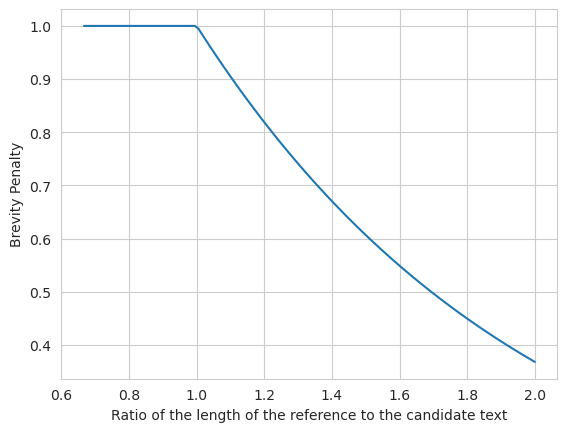

In [2]:
reference_length = 1
candidate_length = np.linspace(1.5, 0.5, 100)

length_ratio = reference_length / candidate_length
BP = np.minimum(1, np.exp(1 - length_ratio))

# Plot the data
fig, ax = plt.subplots(1)
lines = ax.plot(length_ratio, BP)
ax.set(xlabel="Ratio of the length of the reference to the candidate text",
       ylabel="Brevity Penalty")
plt.show()

### N-Gram Precision:
The n-gram precision counts how many n-grams (in your case unigrams, bigrams, trigrams, and four-grams for i =1 , ... , 4) match their n-gram counterpart in the reference translations. This term acts as a precision metric. Unigrams account for adequacy while longer n-grams account for fluency of the translation. To avoid overcounting, the n-gram counts are clipped to the maximal n-gram count occurring in the reference ($m_{n}^{ref}$). Typically precision shows exponential decay with the degree of the n-gram.

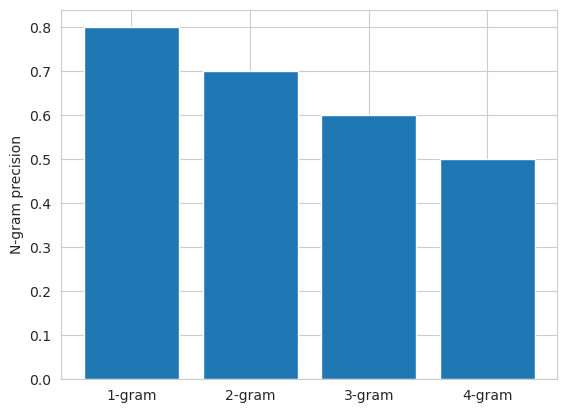

In [3]:
# Mocked dataset showing the precision for different n-grams
data = {"1-gram": 0.8, "2-gram": 0.7, "3-gram": 0.6, "4-gram": 0.5}

# Plot the datapoints defined above
fig, ax = plt.subplots(1)
bars = ax.bar(*zip(*data.items()))
ax.set(ylabel="N-gram precision")
plt.show()

### N-gram BLEU score:
When the n-gram precision is normalized by the brevity penalty (BP), then the exponential decay of n-grams is almost fully compensated. The BLEU score corresponds to a geometric average of this modified n-gram precision.

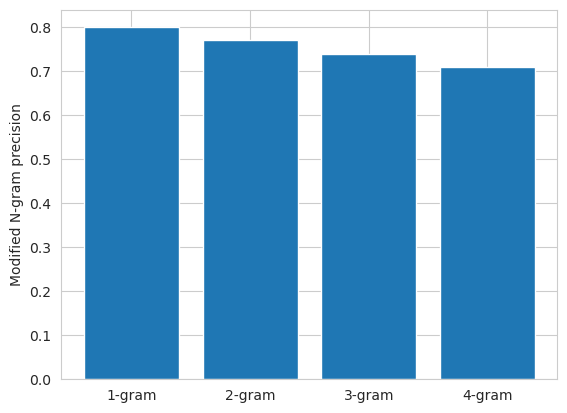

In [4]:
# Mocked dataset showing the precision multiplied by the BP for different n-grams
data = {"1-gram": 0.8, "2-gram": 0.77, "3-gram": 0.74, "4-gram": 0.71}

# Plot the datapoints defined above
fig, ax = plt.subplots(1)
bars = ax.bar(*zip(*data.items()))
ax.set(ylabel="Modified N-gram precision")
plt.show()

# 3. Example Calculations of the BLEU score

In this example you will have a reference sentence and 2 candidate sentences. You will tokenize all sentences using the NLTK package. Then you will compare the two candidates to the reference using BLEU score.

First you define and tokenize the sentences.

In [5]:
reference = "The NASA Opportunity rover is battling a massive dust storm on planet Mars."
candidate_1 = "The Opportunity rover is combating a big sandstorm on planet Mars."
candidate_2 = "A NASA rover is fighting a massive storm on planet Mars."

tokenized_ref = nltk.word_tokenize(reference.lower())
tokenized_cand_1 = nltk.word_tokenize(candidate_1.lower())
tokenized_cand_2 = nltk.word_tokenize(candidate_2.lower())

print(f"{reference} -> {tokenized_ref}")
print("\n")
print(f"{candidate_1} -> {tokenized_cand_1}")
print("\n")
print(f"{candidate_2} -> {tokenized_cand_2}")

The NASA Opportunity rover is battling a massive dust storm on planet Mars. -> ['the', 'nasa', 'opportunity', 'rover', 'is', 'battling', 'a', 'massive', 'dust', 'storm', 'on', 'planet', 'mars', '.']


The Opportunity rover is combating a big sandstorm on planet Mars. -> ['the', 'opportunity', 'rover', 'is', 'combating', 'a', 'big', 'sandstorm', 'on', 'planet', 'mars', '.']


A NASA rover is fighting a massive storm on planet Mars. -> ['a', 'nasa', 'rover', 'is', 'fighting', 'a', 'massive', 'storm', 'on', 'planet', 'mars', '.']


## 3.1 Define the functions to calculate the BLEU score

### Computing the Brevity Penalty
You will start by defining the function for brevity penalty according to the equation (2) in section 2.1.

In [6]:
def brevity_penalty(candidate, reference):
    """
    Calculates the brevity penalty given the candidate and reference sentences.
    """
    reference_length = len(reference)
    candidate_length = len(candidate)

    if reference_length < candidate_length:
        BP = 1
    else:
        penalty = 1 - (reference_length / candidate_length)
        BP = np.exp(penalty)

    return BP

### Computing the clipped Precision
Next, you need to define a function to calculate the geometrically averaged clipped precision. This function calculates how many of the n-grams in the candidate sentence actually appear in the reference sentence. The clipping takes care of overcounting. For example if a certain n-gram appears five times in the candidate sentence, but only twice in the reference, the value is clipped to two.

In [7]:
def average_clipped_precision(candidate, reference):
    """
    Calculates the precision given the candidate and reference sentences.
    """

    clipped_precision_score = []
    
    # Loop through values 1, 2, 3, 4. This is the length of n-grams
    for n_gram_length in range(1, 5):
        reference_n_gram_counts = Counter(ngrams(reference, n_gram_length))        
        candidate_n_gram_counts = Counter(ngrams(candidate, n_gram_length))                

        total_candidate_ngrams = sum(candidate_n_gram_counts.values())       
        
        for ngram in candidate_n_gram_counts: 
            # check if it is in the reference n-gram
            if ngram in reference_n_gram_counts:
                # if the count of the candidate n-gram is bigger than the corresponding
                # count in the reference n-gram, then set the count of the candidate n-gram 
                # to be equal to the reference n-gram
                
                if candidate_n_gram_counts[ngram] > reference_n_gram_counts[ngram]: 
                    candidate_n_gram_counts[ngram] = reference_n_gram_counts[ngram] # t

            else:
                candidate_n_gram_counts[ngram] = 0 # else set the candidate n-gram equal to zero

        clipped_candidate_ngrams = sum(candidate_n_gram_counts.values())
        
        clipped_precision_score.append(clipped_candidate_ngrams / total_candidate_ngrams)
    
    # Calculate the geometric average: take the mean of elemntwise log, then exponentiate
    # This is equivalent to taking the n-th root of the product as shown in equation (1) above
    s = np.exp(np.mean(np.log(clipped_precision_score)))
    
    return s

### Computing the BLEU score
Finally, you can compute the BLEU score using the above two functions.

In [8]:
def bleu_score(candidate, reference):
    BP = brevity_penalty(candidate, reference)
    geometric_average_precision = average_clipped_precision(candidate, reference)

    return BP * geometric_average_precision

## 3.2 Testing the functions
Now you can test the functions with your Example Reference and Candidates Sentences.

In [9]:
result_candidate_1 = round(bleu_score(tokenized_cand_1, tokenized_ref) * 100, 1)
print(f"BLEU score of reference versus candidate 1: {result_candidate_1}")
result_candidate_2 = round(bleu_score(tokenized_cand_2, tokenized_ref) * 100, 1)
print(f"BLEU score of reference versus candidate 2: {result_candidate_2}")

BLEU score of reference versus candidate 1: 27.6
BLEU score of reference versus candidate 2: 35.3


## 3.3 Comparing the Results from your Code with the Sacrebleu Library
Below you will do the same calculation, but using the `sacrebleu` library. Compare them with your implementation above.

In [10]:
result_candidate_1 = round(sacrebleu.sentence_bleu(candidate_1, [reference]).score, 1)
print(f"BLEU score of reference versus candidate 1: {result_candidate_1}")
result_candidate_2 = round(sacrebleu.sentence_bleu(candidate_2, [reference]).score, 1)
print(f"BLEU score of reference versus candidate 2: {result_candidate_2}")

BLEU score of reference versus candidate 1: 27.6
BLEU score of reference versus candidate 2: 35.3


# 4.  BLEU computation on a corpus

## 4.1 Loading Datasets for Evaluation Using the BLEU Score

In this section, you will use a simple pipeline for evaluating machine translated text. You will use English to German translations generated by [Google Translate](https://translate.google.com). There are three files you will need:

1. A source text in English. In this lab, you will use the first 1671 words of the [wmt19](http://statmt.org/wmt19/translation-task.html) evaluation dataset downloaded via SacreBLEU.
2. A reference translation to German of the corresponding first 1671 words from the original English text. This is also provided by SacreBLEU.
3. A candidate machine translation to German from the same 1671 words. This is generated by Google Translate.

With that, you can now compare the reference and candidate translation to get the BLEU Score.

In [11]:
# Loading the raw data
wmt19_src = open("./data/wmt19_src.txt", "r")
wmt19_src_1 = wmt19_src.read()
wmt19_src.close()

wmt19_ref = open("./data/wmt19_ref.txt", "r")
wmt19_ref_1 = wmt19_ref.read()
wmt19_ref.close()

wmt19_can = open("./data/wmt19_can.txt", "r")
wmt19_can_1 = wmt19_can.read()
wmt19_can.close()

tokenized_corpus_src = nltk.word_tokenize(wmt19_src_1.lower())
tokenized_corpus_ref = nltk.word_tokenize(wmt19_ref_1.lower())
tokenized_corpus_cand = nltk.word_tokenize(wmt19_can_1.lower())

Now that you have your data loaded, you can inspect the first sentence of each dataset.

In [12]:
print("English source text:\n")
print(f"{wmt19_src_1[0:170]} -> {tokenized_corpus_src[0:30]}\n\n")
print("German reference translation:\n")
print(f"{wmt19_ref_1[0:219]} -> {tokenized_corpus_ref[0:35]}\n\n")
print("German machine translation:\n")
print(f"{wmt19_can_1[0:199]} -> {tokenized_corpus_cand[0:29]}")

English source text:

﻿Welsh AMs worried about 'looking like muppets'
There is consternation among some AMs at a suggestion their title should change to MWPs (Member of the Welsh Parliament).
 -> ['\ufeffwelsh', 'ams', 'worried', 'about', "'looking", 'like', 'muppets', "'", 'there', 'is', 'consternation', 'among', 'some', 'ams', 'at', 'a', 'suggestion', 'their', 'title', 'should', 'change', 'to', 'mwps', '(', 'member', 'of', 'the', 'welsh', 'parliament', ')']


German reference translation:

﻿Walisische Ageordnete sorgen sich "wie Dödel auszusehen"
Es herrscht Bestürzung unter einigen Mitgliedern der Versammlung über einen Vorschlag, der ihren Titel zu MWPs (Mitglied der walisischen Parlament) ändern soll.
 -> ['\ufeffwalisische', 'ageordnete', 'sorgen', 'sich', '``', 'wie', 'dödel', 'auszusehen', "''", 'es', 'herrscht', 'bestürzung', 'unter', 'einigen', 'mitgliedern', 'der', 'versammlung', 'über', 'einen', 'vorschlag', ',', 'der', 'ihren', 'titel', 'zu', 'mwps', '(', 'mitglied', 'der'

And lastly, you can calculate the BLEU score of the translation.

In [13]:
result =  round(sacrebleu.sentence_bleu(wmt19_can_1, [wmt19_ref_1]).score, 1)
print(f"BLEU score of the reference versus candidate translation: {result}")

BLEU score of the reference versus candidate translation: 43.2


## 4.2 BLEU Score Interpretation on a Corpus
The table below (taken from [here](https://cloud.google.com/translate/automl/docs/evaluate)) shows the typical values of BLEU score. You can see that the translation above is of high quality according to this table and in comparison to the given reference sentence. (*if you see "Hard to get the gist", please open your workspace, delete `wmt19_can.txt` and get the latest version via the Lab Help button*)

|Score      | Interpretation                                                |
|:---------:|:-------------------------------------------------------------:|
| < 10      | Almost useless                                                |
| 10 - 19   | Hard to get the gist                                          |
| 20 - 29   | The gist is clear, but has significant grammatical errors     |
| 30 - 40   | Understandable to good translations                           |
| 40 - 50   | High quality translations                                     |
| 50 - 60   | Very high quality, adequate, and fluent translations          |
| > 60      | Quality often better than human                               |